In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from core.util.io import read_csv

Global parameters.

In [2]:
batch_size = 8
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()

Read the preprocessed Trefor data and print for validation.

In [3]:
data = read_csv("core/data/processed/trefor_final.csv")

data

,Total_Consumption,Total_Consumption(t-5),Total_Consumption(t-4),Total_Consumption(t-3),Total_Consumption(t-2),Total_Consumption(t-1)
0,146.108,227.852,227.971,213.314,189.091,167.948
1,132.478,227.971,213.314,189.091,167.948,146.108
2,125.822,213.314,189.091,167.948,146.108,132.478
3,139.345,189.091,167.948,146.108,132.478,125.822
4,183.487,167.948,146.108,132.478,125.822,139.345
...,...,...,...,...,...,...
17510,356.097,398.229,386.921,406.370,384.986,415.585
17511,280.467,386.921,406.370,384.986,415.585,356.097
17512,265.300,406.370,384.986,415.585,356.097,280.467
17513,228.468,384.986,415.585,356.097,280.467,265.300


Use CUDA if available.

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

device

'cpu'

Convert dataframe to numpy.

In [5]:
data_as_numpy = data.to_numpy()

data_as_numpy

array([[146.108, 227.852, 227.971, 213.314, 189.091, 167.948],
       [132.478, 227.971, 213.314, 189.091, 167.948, 146.108],
       [125.822, 213.314, 189.091, 167.948, 146.108, 132.478],
       ...,
       [265.3  , 406.37 , 384.986, 415.585, 356.097, 280.467],
       [228.468, 384.986, 415.585, 356.097, 280.467, 265.3  ],
       [208.7  , 415.585, 356.097, 280.467, 265.3  , 228.468]])

Normalize data to improve trainability.

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_as_numpy)

data_normalized

array([[0.1039824 , 0.19039374, 0.19051953, 0.17502566, 0.1494196 ,
        0.1270694 ],
       [0.08957417, 0.19051953, 0.17502566, 0.1494196 , 0.1270694 ,
        0.1039824 ],
       [0.08253813, 0.17502566, 0.1494196 , 0.1270694 , 0.1039824 ,
        0.08957417],
       ...,
       [0.2299799 , 0.37910458, 0.35649961, 0.38884572, 0.32596114,
        0.24601289],
       [0.19104491, 0.35649961, 0.38884572, 0.32596114, 0.24601289,
        0.2299799 ],
       [0.17014822, 0.38884572, 0.32596114, 0.24601289, 0.2299799 ,
        0.19104491]])

Split numpy array into feature and target.

In [7]:
X = data_normalized[:, 1:]  # Features
Y = data_normalized[:, 0]  # Target

Split dataset into a training set and a validation set. Split index is set with a global variable.

In [8]:
split_index = int(len(X) * 0.80)

X_train, Y_train = X[:split_index], Y[:split_index]
X_test, Y_test = X[split_index:], Y[split_index:]

# Something something lstm needs an extra dimension? If removed it does not run.
X_train = X_train.reshape((-1, 5, 1))
X_test = X_test.reshape((-1, 5, 1))

Y_train = Y_train.reshape((-1, 1))
Y_test = Y_test.reshape((-1, 1))

Convert the datasets to tensors.

In [9]:
x_train = torch.tensor(X_train).float()
y_train = torch.tensor(Y_train).float()
x_test = torch.tensor(X_test).float()
y_test = torch.tensor(Y_test).float()

Create the dataset and initialize training and test datasets with our data

In [10]:
class TreforData(Dataset):
    """Initialize Trefor dataset."""

    def __init__(self, x: torch.tensor, y: torch.tensor) -> None:
        """Initialize dataset.

        Arguments:
            x: feature as torch
            y: target as torch

        """
        self.x = x
        self.y = y

    def __len__(self) -> int:
        """Return length of dataset."""
        return len(self.x)

    def __getitem__(self, i: int) -> tuple:
        """Return tuple from dataset."""
        return self.x[i], self.y[i]


train_dataset = TreforData(x_train, y_train)
test_dataset = TreforData(x_test, y_test)

Load data into a dataloader with specified batch size from global parameter.

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Initialize the ML model. This is an example and should be changed to fit our scenario.

In [12]:
class LSTM(nn.Module):
    """Super scuffed LSTM."""

    def __init__(
        self, input_size: int, hidden_size: int, num_stacked_layers: int
    ) -> None:
        """Subject to change."""
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_stacked_layers, batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Subject to change."""
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(
            device
        )

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Train epoch. This is an example and should be changed to fit our scenario.

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train_one_epoch() -> None:
    """Subject to change."""
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 256 == 0:
            avg_loss_across_batches = running_loss / batch_size
            print(
                "Batch {0}, AvgLoss: {1:.3f}".format(
                    batch_index + 1, avg_loss_across_batches
                )
            )
        running_loss = 0.0

    print()

Validate epoch. This is an example and should be changed to fit our scenario.

In [14]:
def validate_one_epoch() -> None:
    """Subject to change."""
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("***************************************************")
    print()

Train and validate the model. This is an example and should be changed to fit our scenario.

In [15]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 1, AvgLoss: 0.005
Batch 257, AvgLoss: 0.000
Batch 513, AvgLoss: 0.001
Batch 769, AvgLoss: 0.001
Batch 1025, AvgLoss: 0.001
Batch 1281, AvgLoss: 0.004
Batch 1537, AvgLoss: 0.002

Val Loss: 0.016
***************************************************

Epoch: 2
Batch 1, AvgLoss: 0.000
Batch 257, AvgLoss: 0.000
Batch 513, AvgLoss: 0.001
Batch 769, AvgLoss: 0.000
Batch 1025, AvgLoss: 0.000
Batch 1281, AvgLoss: 0.002
Batch 1537, AvgLoss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 3
Batch 1, AvgLoss: 0.000
Batch 257, AvgLoss: 0.000
Batch 513, AvgLoss: 0.000
Batch 769, AvgLoss: 0.000
Batch 1025, AvgLoss: 0.000
Batch 1281, AvgLoss: 0.001
Batch 1537, AvgLoss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 1, AvgLoss: 0.000
Batch 257, AvgLoss: 0.000
Batch 513, AvgLoss: 0.000
Batch 769, AvgLoss: 0.000
Batch 1025, AvgLoss: 0.000
Batch 1281, AvgLoss: 0.001
Batch 1537, AvgLoss: 0.001

Val Loss: 0.004
*****

Visualize model performance. This is an example and should be changed to fit our scenario. Currently the data is not inversed from normalization.

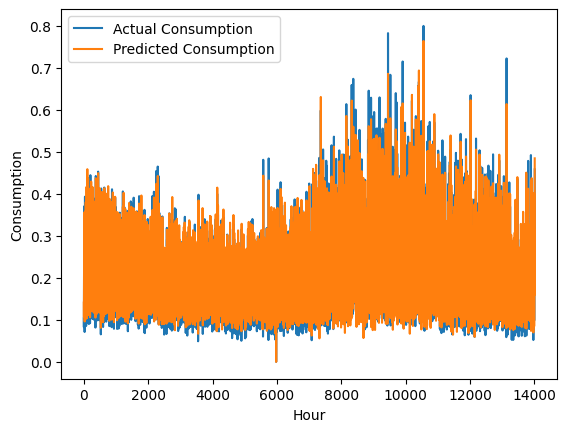

In [16]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to("cpu").numpy()

plt.plot(Y_train, label="Actual Consumption")
plt.plot(predicted, label="Predicted Consumption")
plt.xlabel("Hour")
plt.ylabel("Consumption")
plt.legend()
plt.show()